In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, f_oneway

# Set global plot style
sns.set_style("whitegrid")

In [3]:
data = pd.read_csv("/content/Twitter A_B testing.csv")
df = pd.DataFrame(data)

In [4]:
# Handle missing values
df = df.fillna({'treatment': 'NA', 'company_size': 'NA', 'campaign_spend': 'NA', 'campaign_budget': 'NA'})

# Remove duplicates
df = df.drop_duplicates()

# Display cleaned data
df.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


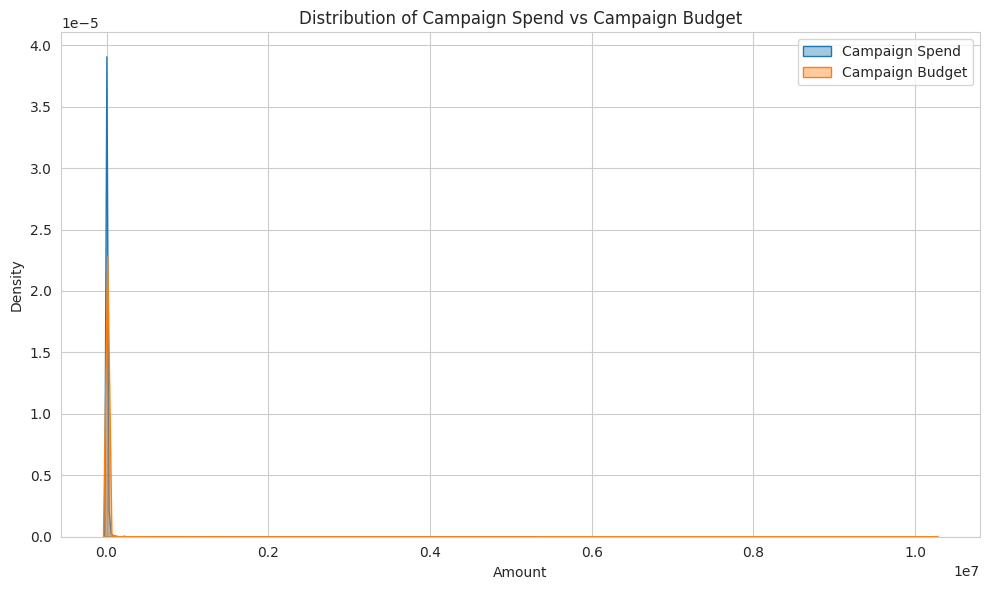

In [19]:
# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['campaign_spend'], label='Campaign Spend', fill=True, alpha=0.4)
sns.kdeplot(df['campaign_budget'], label='Campaign Budget', fill=True, alpha=0.4)
plt.title('Distribution of Campaign Spend vs Campaign Budget')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Control Group Overspent Campaigns: 5716
Treatment Group Overspent Campaigns: 5180


<ipython-input-5-9513567ca990>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=['Control Group', 'Treatment Group'],


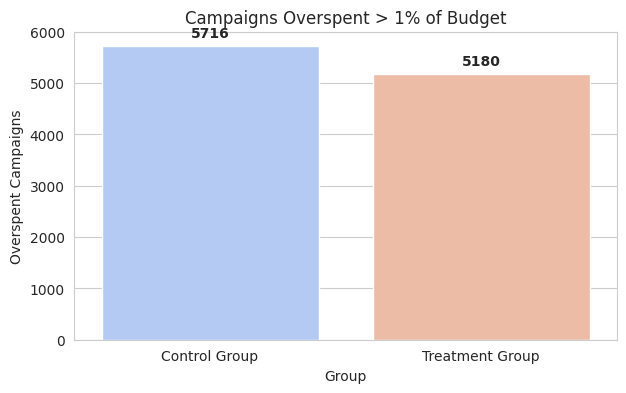

In [5]:
# 1. Overspend Count
data['overspend_percentage'] = (data['campaign_spend'] - data['campaign_budget']) / data['campaign_budget'] * 100
overspent_control = data[(data['treatment'] == False) & (data['overspend_percentage'] > 1)]
overspent_treatment = data[(data['treatment'] == True) & (data['overspend_percentage'] > 1)]

count_overspent_control = len(overspent_control)
count_overspent_treatment = len(overspent_treatment)

print(f"Control Group Overspent Campaigns: {count_overspent_control}")
print(f"Treatment Group Overspent Campaigns: {count_overspent_treatment}")

plt.figure(figsize=(7, 4))
barplot = sns.barplot(x=['Control Group', 'Treatment Group'],
                      y=[count_overspent_control, count_overspent_treatment],
                      palette='coolwarm')

for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     fontsize=10, fontweight='bold',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.xlabel('Group')
plt.ylabel('Overspent Campaigns')
plt.title('Campaigns Overspent > 1% of Budget')
plt.show()


  company_size  treatment    overspend  overspend_percentage
0        large      False  -529.401212             12.293655
1        large       True -3488.030867              3.263995
2       medium      False -1869.091717              4.557030
3       medium       True  -938.334240              5.144382
4        small      False  -591.025617             37.064162
5        small       True   231.331618             27.096085


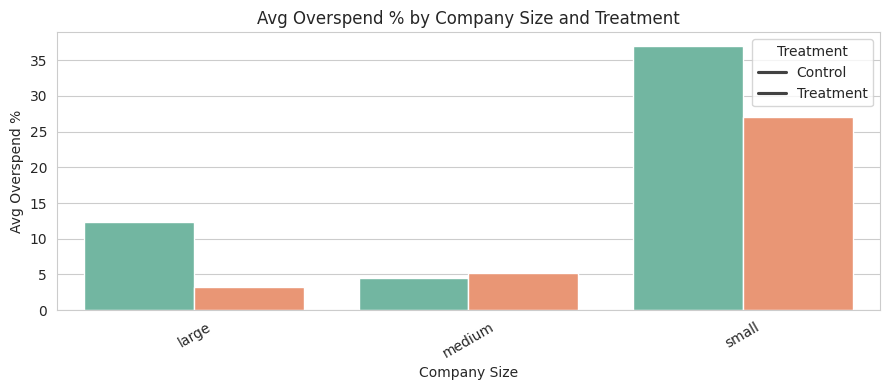

In [22]:
# 2. Effectiveness by Company Size

# Calculate overspend as the difference between spend and budget
df['overspend'] = df['campaign_spend'] - df['campaign_budget']

# Calculate overspend percentage relative to budget (optional but useful)
df['overspend_percentage'] = (df['overspend'] / df['campaign_budget']) * 100

# Group by company size and treatment, then calculate mean overspend and mean overspend percentage
overspend_summary = df.groupby(['company_size', 'treatment']).agg({
    'overspend': 'mean',
    'overspend_percentage': 'mean'
}).reset_index()

print(overspend_summary)



plt.figure(figsize=(9, 4))
sns.barplot(data=overspend_by_company_size,
            x='company_size', y='overspend_percentage',
            hue='treatment', palette='Set2')
plt.xlabel('Company Size')
plt.ylabel('Avg Overspend %')
plt.title('Avg Overspend % by Company Size and Treatment')
plt.legend(title='Treatment', labels=['Control', 'Treatment'])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Summary Stats for Campaign Budget:
                  mean   median            std  count
treatment                                            
False      4641.827622  65.3784   47765.753797   7733
True       6902.232566  38.5950  131623.544113   7741

Mann-Whitney U Test p-value: 1.4666245003711244e-26


<ipython-input-23-d4e5573110e1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='treatment', y='campaign_budget', palette='pastel')


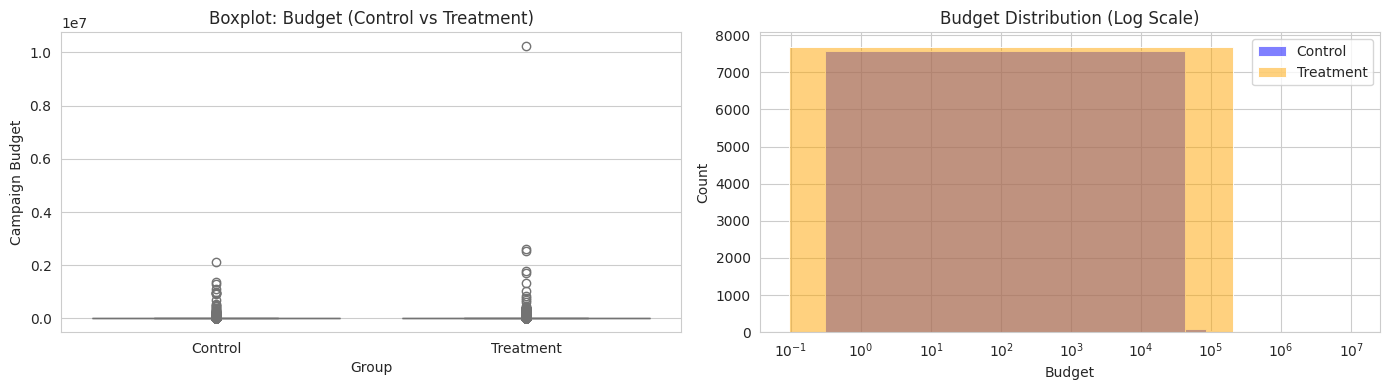

In [23]:
# 3. Suspicion on Budgets
summary_stats = df.groupby('treatment')['campaign_budget'].agg(['mean', 'median', 'std', 'count'])
print("\nSummary Stats for Campaign Budget:")
print(summary_stats)

stat, p_value = stats.mannwhitneyu(
    df[df['treatment'] == True]['campaign_budget'],
    df[df['treatment'] == False]['campaign_budget'],
    alternative='two-sided'
)
print("\nMann-Whitney U Test p-value:", p_value)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='treatment', y='campaign_budget', palette='pastel')
plt.xlabel('Group')
plt.ylabel('Campaign Budget')
plt.title('Boxplot: Budget (Control vs Treatment)')
plt.xticks([0, 1], ['Control', 'Treatment'])

plt.subplot(1, 2, 2)
sns.histplot(data=df[df['treatment'] == False], x='campaign_budget', bins=50,
             label='Control', color='blue', alpha=0.5)
sns.histplot(data=df[df['treatment'] == True], x='campaign_budget', bins=50,
             label='Treatment', color='orange', alpha=0.5)
plt.xscale('log')
plt.title('Budget Distribution (Log Scale)')
plt.xlabel('Budget')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()



Average Overspend % by Group:
treatment
False    25.32255
True     17.60635
Name: overspend_percentage, dtype: float64


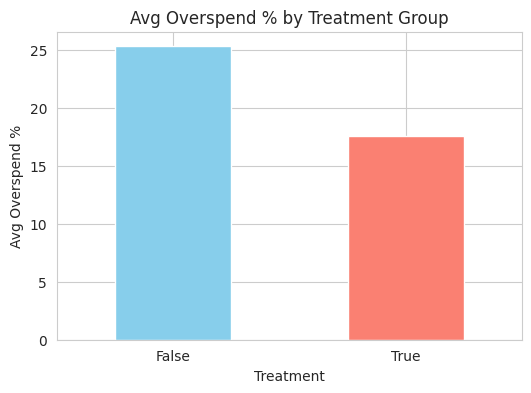

In [9]:
# 4. Average Overspend % Bar Chart
df['overspend_percentage'] = (df['campaign_spend'] - df['campaign_budget']) / df['campaign_budget'] * 100
overspend_stats = df.groupby('treatment')['overspend_percentage'].mean()
print("\nAverage Overspend % by Group:")
print(overspend_stats)

plt.figure(figsize=(6, 4))
overspend_stats.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Avg Overspend % by Treatment Group')
plt.xlabel('Treatment')
plt.ylabel('Avg Overspend %')
plt.xticks(rotation=0)
plt.show()



Overspend by Company Size and Group:
                          mean  count    std
company_size treatment                     
large        False      12.29   2701  53.98
             True        3.26   2445  45.24
medium       False       4.56    735  39.97
             True        5.14    692  46.54
small        False      37.06   4297  86.02
             True       27.10   4604  81.03


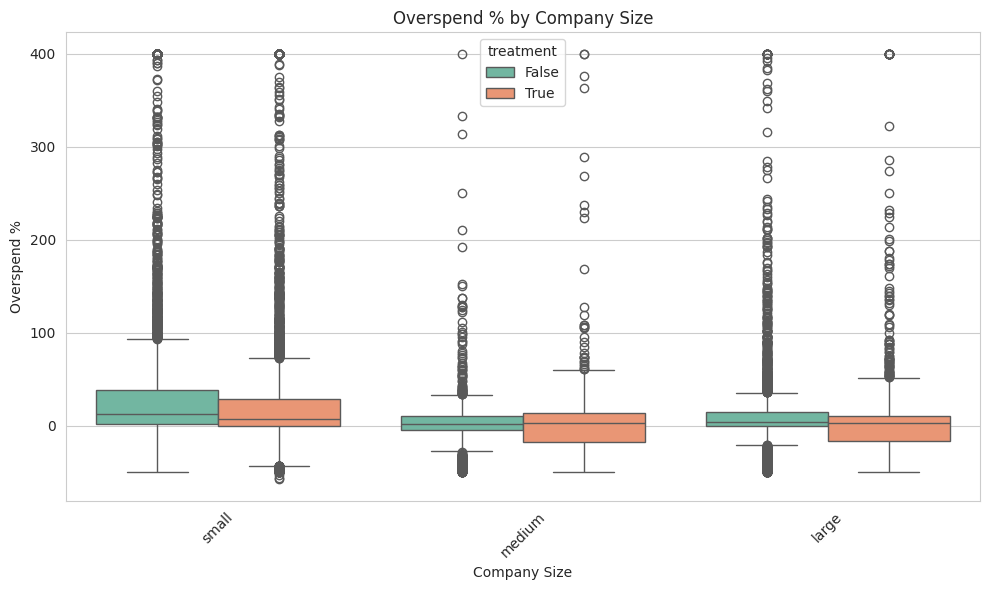


Statistical Tests by Company Size:
Company Size: small | p-value: 0.000000
Company Size: medium | p-value: 0.729664
Company Size: large | p-value: 0.000000


In [11]:
# 6. Demographics vs Overspend
overspend_by_size = df.groupby(['company_size', 'treatment'])['overspend_percentage'].agg(['mean', 'count', 'std']).round(2)
print("\nOverspend by Company Size and Group:\n", overspend_by_size)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='company_size', y='overspend_percentage', hue='treatment', palette='Set2')
plt.title('Overspend % by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Overspend %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Company Size Test Loop
print("\nStatistical Tests by Company Size:")
for size in df['company_size'].unique():
    size_data = df[df['company_size'] == size]
    control = size_data[size_data['treatment'] == False]['overspend_percentage']
    treatment = size_data[size_data['treatment'] == True]['overspend_percentage']
    stat, pval = stats.mannwhitneyu(control, treatment, alternative='two-sided')
    print(f"Company Size: {size} | p-value: {pval:.6f}")

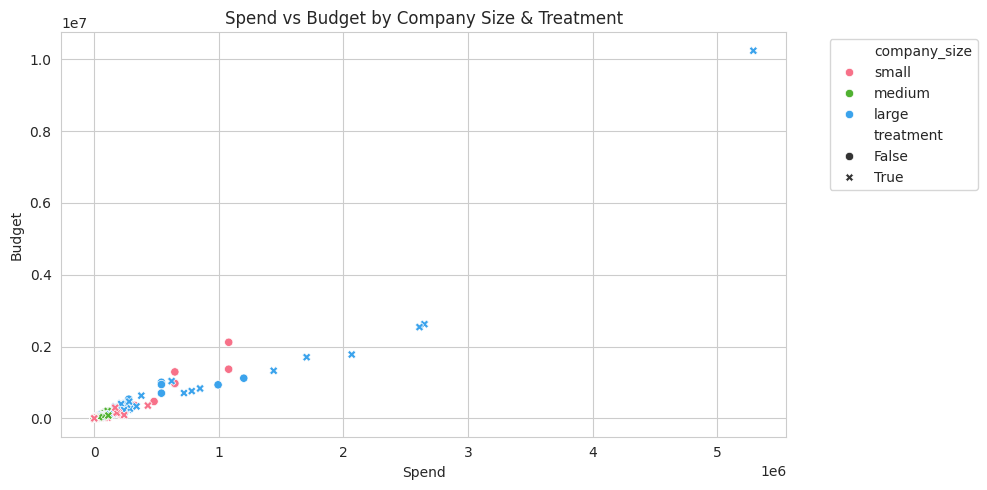

In [12]:
# 7. Engagement Metrics (Visual Only)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data,
                x='campaign_spend',
                y='campaign_budget',
                hue='company_size',
                style='treatment',
                palette='husl')
plt.xlabel('Spend')
plt.ylabel('Budget')
plt.title('Spend vs Budget by Company Size & Treatment')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Mann-Whitney Test on % Budget Spent
Statistic: 32720292.5  | p-value: 1.0098631263116081e-23


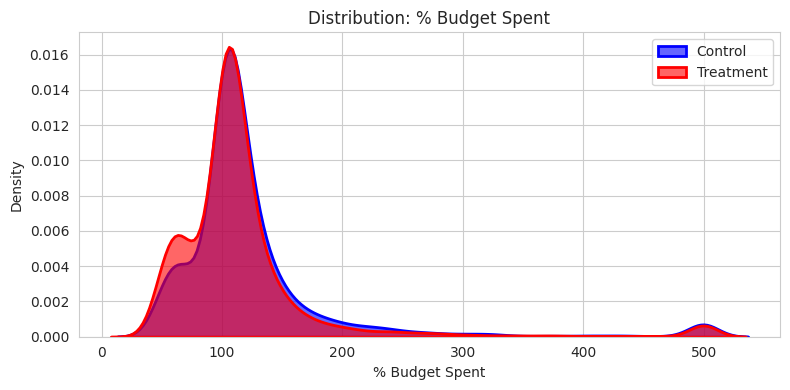

In [13]:
# 8. Budget Spent % Test and Visualization
df['percent_budget_spent'] = (df['campaign_spend'] / df['campaign_budget']) * 100

control_group = df[df['treatment'] == False]['percent_budget_spent']
treatment_group = df[df['treatment'] == True]['percent_budget_spent']

stat, p_value = mannwhitneyu(control_group, treatment_group, alternative='two-sided')
print("\nMann-Whitney Test on % Budget Spent")
print("Statistic:", stat, " | p-value:", p_value)

plt.figure(figsize=(8, 4))
sns.kdeplot(control_group, label='Control', fill=True, alpha=0.6, linewidth=2, color='blue')
sns.kdeplot(treatment_group, label='Treatment', fill=True, alpha=0.6, linewidth=2, color='red')
plt.title('Distribution: % Budget Spent')
plt.xlabel('% Budget Spent')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

ANOVA results for control group: F-statistic = 129.49521678679707, p-value = 4.814444611772025e-56
ANOVA results for treatment group: F-statistic = 107.99521938771012, p-value = 5.507107829400309e-47


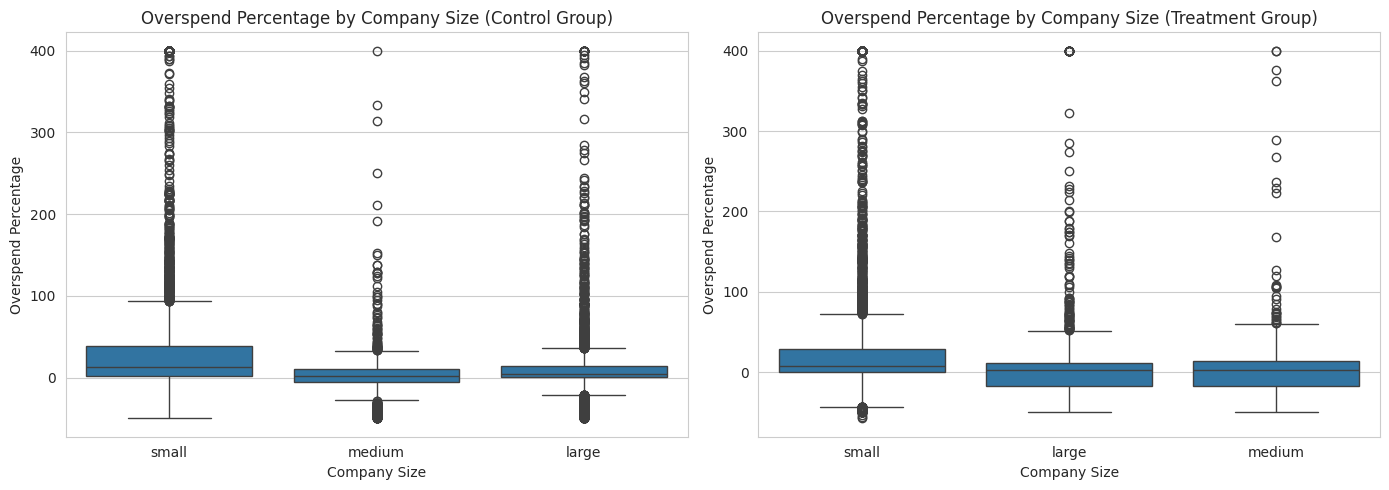

In [14]:
#9) Does company size have a significant impact on the overspend percentage in both control and treatment groups?

from scipy.stats import f_oneway

df['overspend_percentage'] = (df['campaign_spend'] - df['campaign_budget']) / df['campaign_budget'] * 100

control_group = df[df['treatment'] == False]
treatment_group = df[df['treatment'] == True]

# Perform ANOVA to determine if company size has a significant impact on the overspend percentage in both groups
anova_control = f_oneway(
    control_group[control_group['company_size'] == 'small']['overspend_percentage'],
    control_group[control_group['company_size'] == 'medium']['overspend_percentage'],
    control_group[control_group['company_size'] == 'large']['overspend_percentage']
)

anova_treatment = f_oneway(
    treatment_group[treatment_group['company_size'] == 'small']['overspend_percentage'],
    treatment_group[treatment_group['company_size'] == 'medium']['overspend_percentage'],
    treatment_group[treatment_group['company_size'] == 'large']['overspend_percentage']
)

# Print the results
print(f"ANOVA results for control group: F-statistic = {anova_control.statistic}, p-value = {anova_control.pvalue}")
print(f"ANOVA results for treatment group: F-statistic = {anova_treatment.statistic}, p-value = {anova_treatment.pvalue}")

# Create a box plot to visualize the overspend percentage by company size in both groups
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=control_group, x='company_size', y='overspend_percentage')
plt.title('Overspend Percentage by Company Size (Control Group)')
plt.xlabel('Company Size')
plt.ylabel('Overspend Percentage')

plt.subplot(1, 2, 2)
sns.boxplot(data=treatment_group, x='company_size', y='overspend_percentage')
plt.title('Overspend Percentage by Company Size (Treatment Group)')
plt.xlabel('Company Size')
plt.ylabel('Overspend Percentage')

plt.tight_layout()
plt.show()

Levene's test statistic: 3.3277479228868083
P-value: 0.06813936822544886
There is no statistically significant difference in the variance of campaign spend between the control and treatment groups.


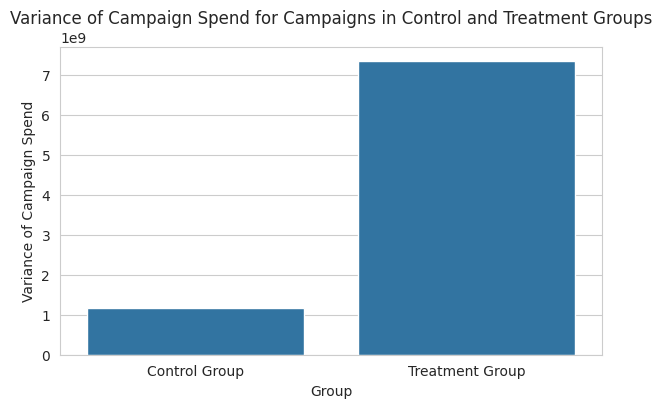

In [15]:
#10) Is the variance in campaign spend significantly different between the control and treatment groups?

from scipy.stats import levene

control_group = df[df['treatment'] == False]
treatment_group = df[df['treatment'] == True]

# Perform Levene's test to compare the variances of campaign spend between the control and treatment groups
stat, p_value = levene(control_group['campaign_spend'], treatment_group['campaign_spend'])

# Print the results
print(f"Levene's test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation of results
if p_value < 0.05:
    print("There is a statistically significant difference in the variance of campaign spend between the control and treatment groups.")
else:
    print("There is no statistically significant difference in the variance of campaign spend between the control and treatment groups.")

# Calculate the variance of campaign spend for each group
variance_control = control_group['campaign_spend'].var()
variance_treatment = treatment_group['campaign_spend'].var()

# Create a bar plot to visualize the variance of campaign spend for each group
plt.figure(figsize=(7, 4))
sns.barplot(x=['Control Group', 'Treatment Group'], y=[variance_control, variance_treatment])
plt.xlabel('Group')
plt.ylabel('Variance of Campaign Spend')
plt.title('Variance of Campaign Spend for Campaigns in Control and Treatment Groups')
plt.show()